In [40]:
import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

cuda:0


In [41]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor
from catboost import CatBoostClassifier


import warnings


# 경고 무시
warnings.filterwarnings("ignore", category=FutureWarning)

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'  # 예시로 'NanumGothic'을 사용

In [42]:
train = pd.read_csv("../data/train.csv")
test = pd.read_csv("../data/test.csv")

In [43]:
train = train.drop(['ID'], axis=1)


In [44]:
train

,대출금액,대출기간,근로기간,주택소유상태,연간소득,부채_대비_소득_비율,총계좌수,대출목적,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수,대출등급
0,12480000,36 months,6 years,RENT,72000000,18.90,15,부채 통합,0,0,0.0,0.0,0.0,C
1,14400000,60 months,10+ years,MORTGAGE,130800000,22.33,21,주택 개선,0,373572,234060.0,0.0,0.0,B
2,12000000,36 months,5 years,MORTGAGE,96000000,8.60,14,부채 통합,0,928644,151944.0,0.0,0.0,A
3,14400000,36 months,8 years,MORTGAGE,132000000,15.09,15,부채 통합,0,325824,153108.0,0.0,0.0,C
4,18000000,60 months,Unknown,RENT,71736000,25.39,19,주요 구매,0,228540,148956.0,0.0,0.0,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96289,14400000,36 months,10+ years,MORTGAGE,210000000,9.33,33,신용 카드,0,974580,492168.0,0.0,0.0,C
96290,28800000,60 months,10+ years,MORTGAGE,132000000,5.16,25,주택 개선,0,583728,855084.0,0.0,0.0,E
96291,14400000,36 months,1 year,MORTGAGE,84000000,11.24,22,신용 카드,0,1489128,241236.0,0.0,0.0,A
96292,15600000,36 months,5 years,MORTGAGE,66330000,17.30,21,부채 통합,2,1378368,818076.0,0.0,0.0,D


In [45]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96294 entries, 0 to 96293
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   대출금액          96294 non-null  int64  
 1   대출기간          96294 non-null  object 
 2   근로기간          96294 non-null  object 
 3   주택소유상태        96294 non-null  object 
 4   연간소득          96294 non-null  int64  
 5   부채_대비_소득_비율   96294 non-null  float64
 6   총계좌수          96294 non-null  int64  
 7   대출목적          96294 non-null  object 
 8   최근_2년간_연체_횟수  96294 non-null  int64  
 9   총상환원금         96294 non-null  int64  
 10  총상환이자         96294 non-null  float64
 11  총연체금액         96294 non-null  float64
 12  연체계좌수         96294 non-null  float64
 13  대출등급          96294 non-null  object 
dtypes: float64(4), int64(5), object(5)
memory usage: 10.3+ MB


In [46]:
label_encoder = LabelEncoder()

train['대출기간'] = label_encoder.fit_transform(train['대출기간'])

In [47]:
# train[train['근로기간'] == '10+years']['근로기간'] = '10+ years'
train.loc[train['근로기간'] == '10+years','근로기간'] = '10+ years'
train.loc[train['근로기간'] == '<1 year','근로기간'] = '< 1 year'
train.loc[train['근로기간'] == '1 years','근로기간'] = '1 year'
train.loc[train['근로기간'] == '3','근로기간'] = '3 years'
train.loc[train['근로기간'] == 'Unknown','근로기간'] = 0
train.loc[train['근로기간'] == '1 year','근로기간'] = 1
train.loc[train['근로기간'] == '2 years','근로기간'] = 1
train.loc[train['근로기간'] == '3 years','근로기간'] = 2
train.loc[train['근로기간'] == '4 years','근로기간'] = 2
train.loc[train['근로기간'] == '5 years','근로기간'] =2
train.loc[train['근로기간'] == '6 years','근로기간'] = 3
train.loc[train['근로기간'] == '7 years','근로기간'] = 3
train.loc[train['근로기간'] == '8 years','근로기간'] =3
train.loc[train['근로기간'] == '9 years','근로기간'] = 3
train.loc[train['근로기간'] == '10+ years','근로기간'] = 4
train.loc[train['근로기간'] == '< 1 year','근로기간'] = 1

train.loc[train['대출등급'] == 'A','대출등급'] = 0
train.loc[train['대출등급'] == 'B','대출등급'] = 1
train.loc[train['대출등급'] == 'C','대출등급'] = 2
train.loc[train['대출등급'] == 'D','대출등급'] = 3
train.loc[train['대출등급'] == 'E','대출등급'] = 4
train.loc[train['대출등급'] == 'F','대출등급'] = 5
train.loc[train['대출등급'] == 'G','대출등급'] = 6

train['대출기간'] = train['대출기간'].astype('category')
train['주택소유상태'] =  train['주택소유상태'].astype('category')
train['대출목적'] =  train['대출목적'].astype('category')
train['대출등급']= train['대출등급'].astype('category')
train['근로기간']= train['근로기간'].astype(float)

In [48]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96294 entries, 0 to 96293
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   대출금액          96294 non-null  int64   
 1   대출기간          96294 non-null  category
 2   근로기간          96294 non-null  float64 
 3   주택소유상태        96294 non-null  category
 4   연간소득          96294 non-null  int64   
 5   부채_대비_소득_비율   96294 non-null  float64 
 6   총계좌수          96294 non-null  int64   
 7   대출목적          96294 non-null  category
 8   최근_2년간_연체_횟수  96294 non-null  int64   
 9   총상환원금         96294 non-null  int64   
 10  총상환이자         96294 non-null  float64 
 11  총연체금액         96294 non-null  float64 
 12  연체계좌수         96294 non-null  float64 
 13  대출등급          96294 non-null  category
dtypes: category(4), float64(5), int64(5)
memory usage: 7.7 MB


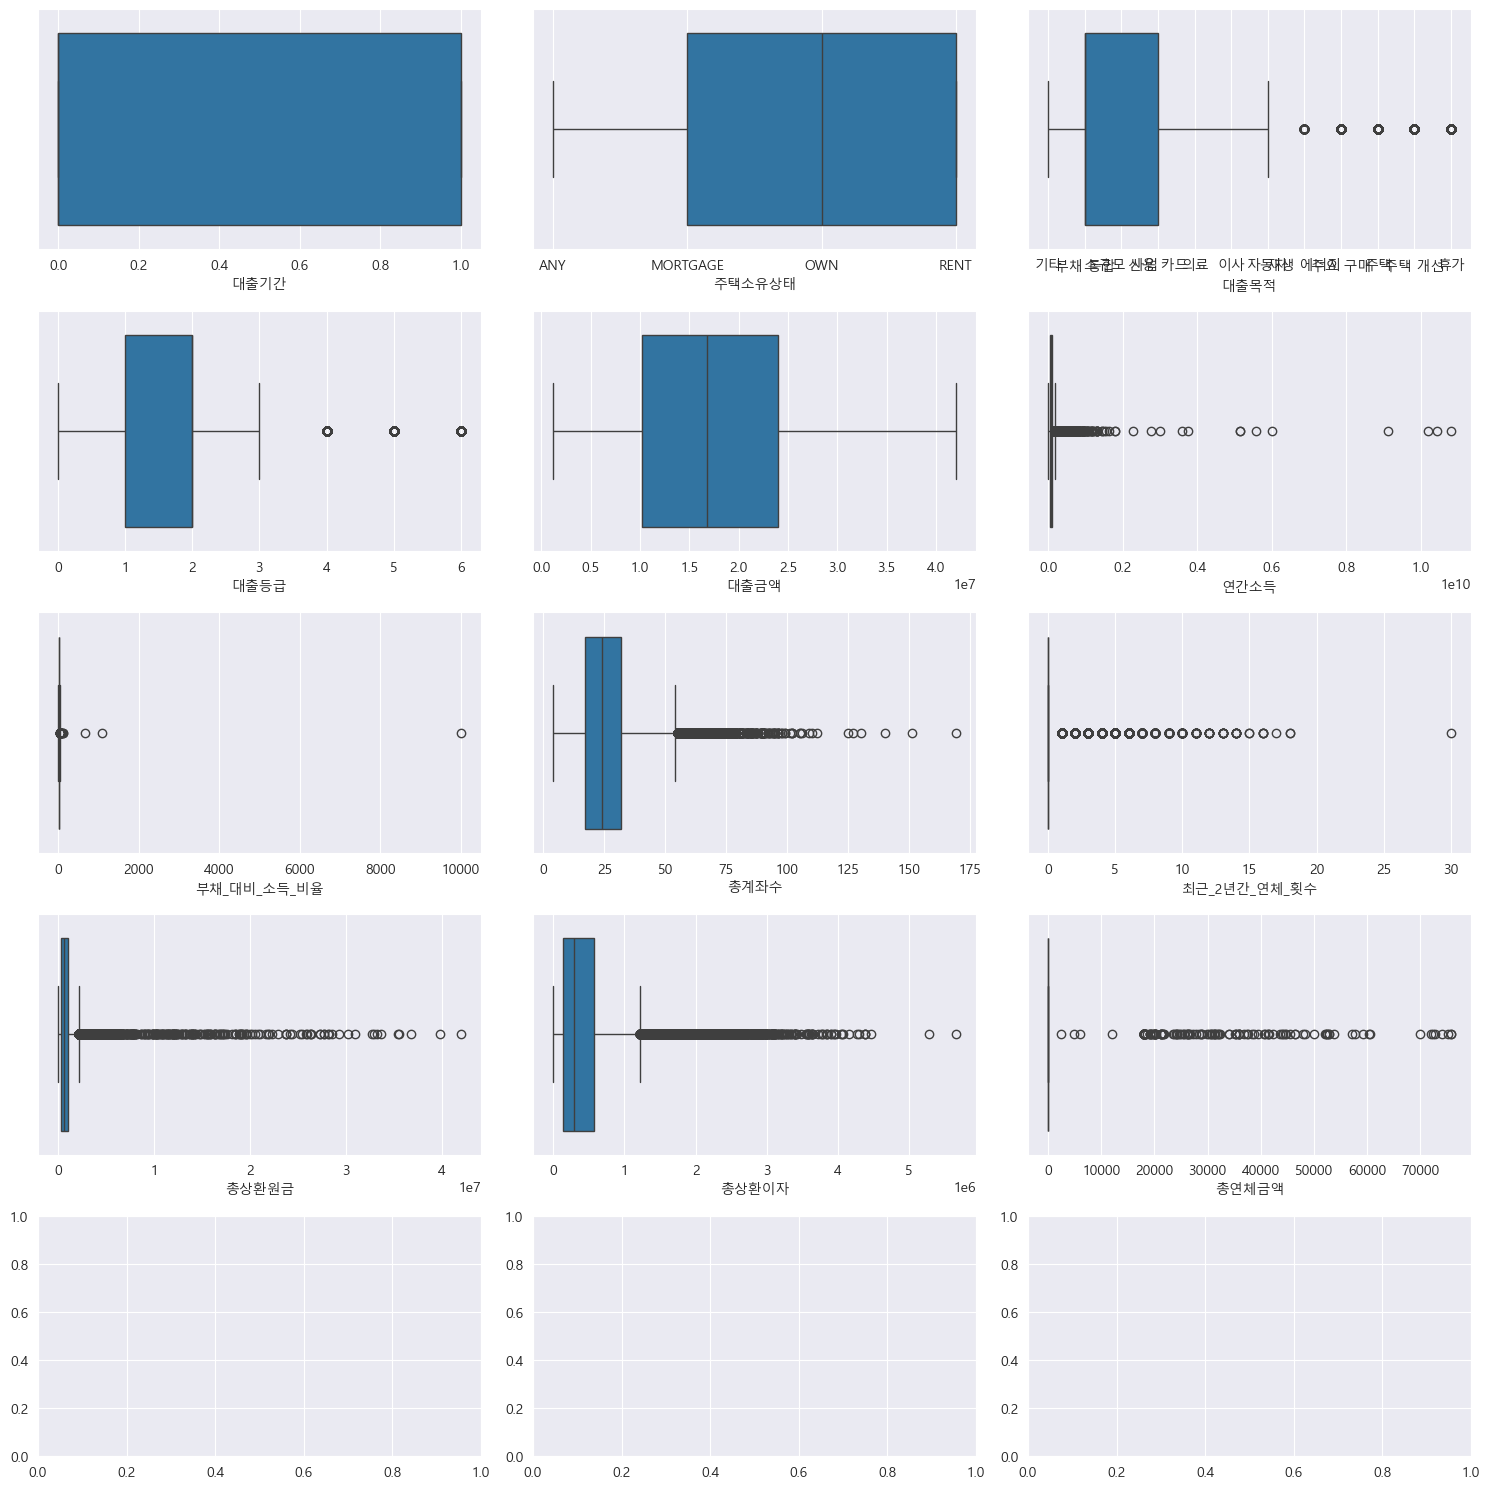

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

# 수치형 열 리스트
numeric_cols = ['대출기간', '주택소유상태','대출목적','대출등급','대출금액', '연간소득', '부채_대비_소득_비율', '총계좌수',
                '최근_2년간_연체_횟수', '총상환원금', '총상환이자', '총연체금액',
                '연체계좌수']

# 4x3 박스플롯 그리기
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(15, 15))
a = 0

# 각각의 subplot에 박스플롯 그리기
for i in range(4):
    for j in range(3):
        if a < len(numeric_cols):
            sns.boxplot(x=numeric_cols[a], data=train, ax=axes[i, j])
            a += 1
        else:
            axes[i, j].set_visible(False)  # 비어있는 서브플롯 숨기기

# 레이아웃 조정
plt.tight_layout()

# 그래프 표시
plt.show()

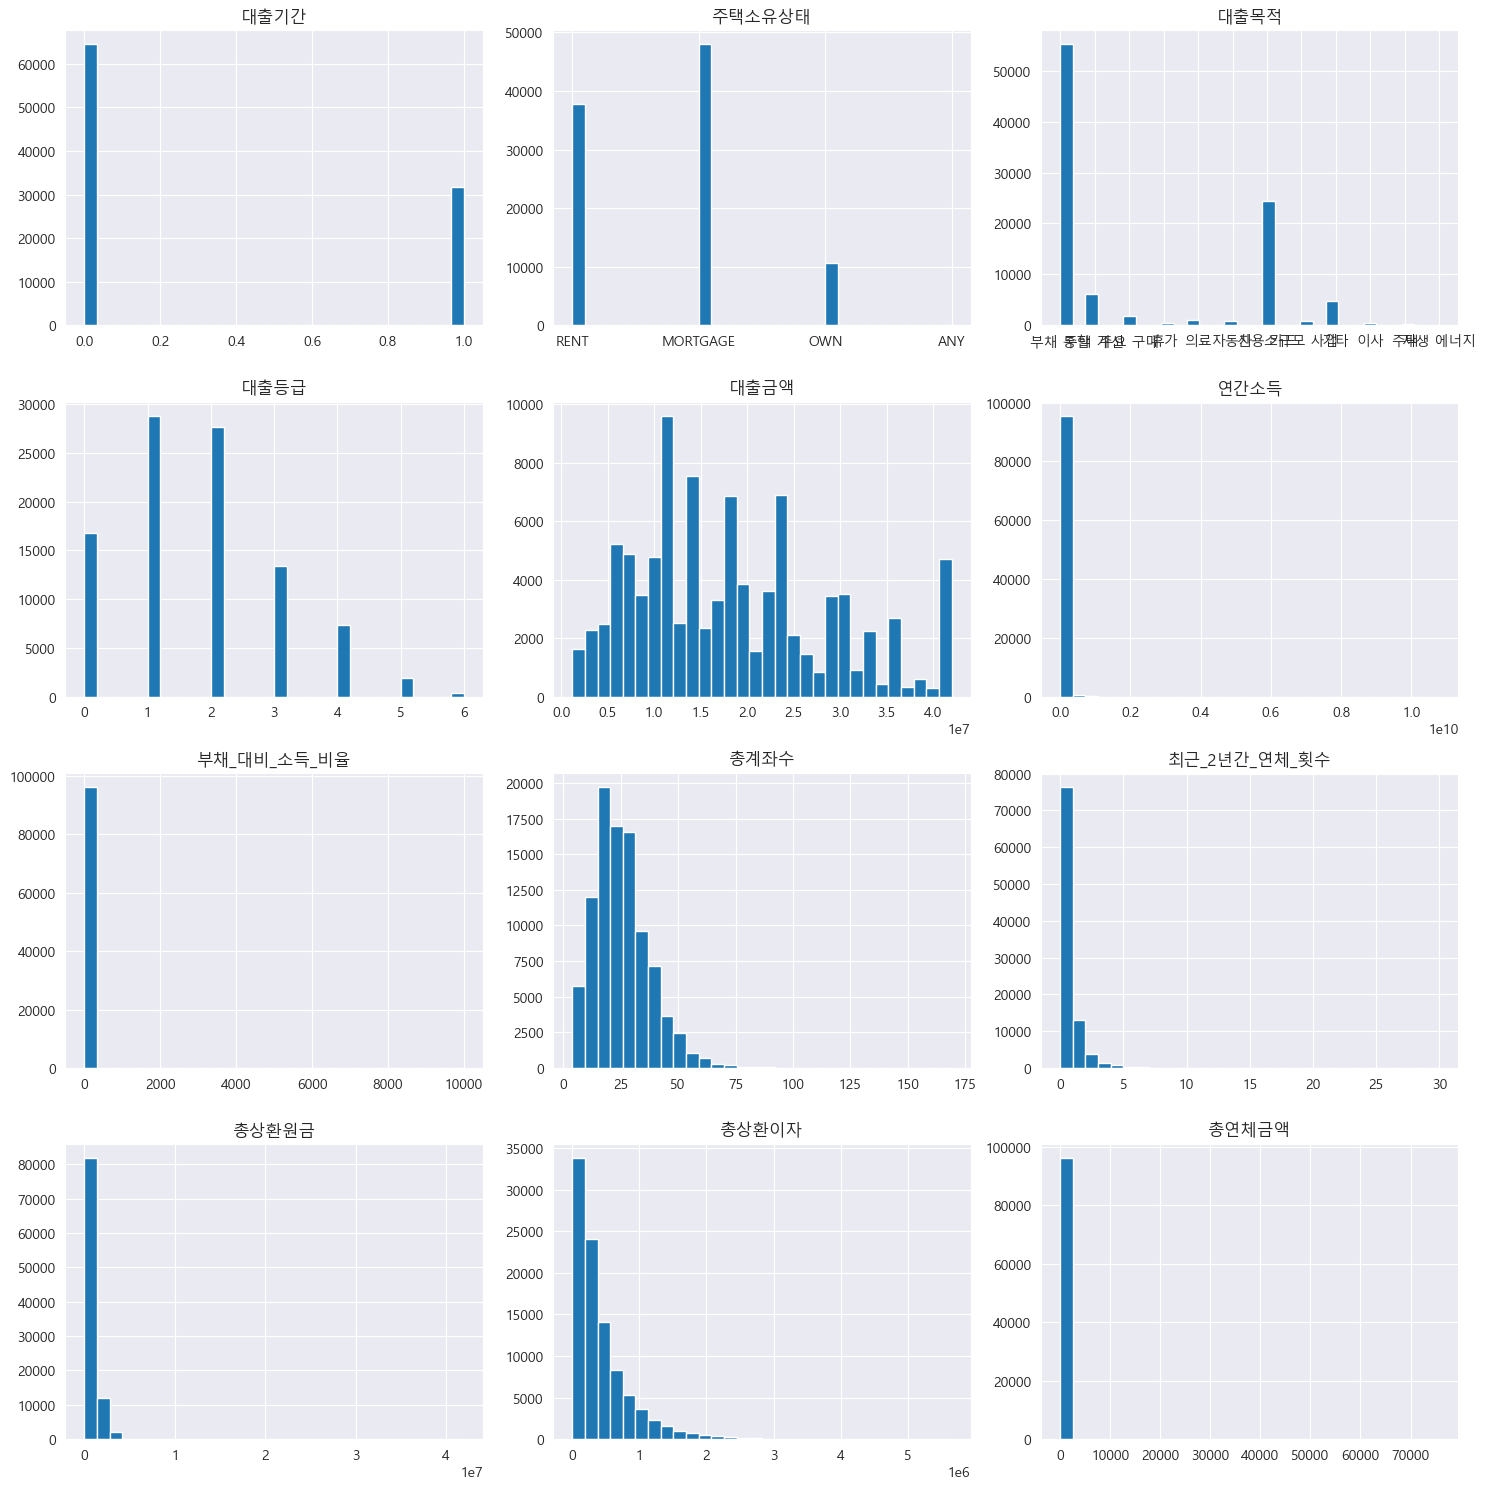

In [18]:
# 4x3 히스토그램 그리기
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 15))
a = 0
numeric_cols = ['대출기간', '주택소유상태','대출목적','대출등급','대출금액', '연간소득', '부채_대비_소득_비율', '총계좌수',
                '최근_2년간_연체_횟수', '총상환원금', '총상환이자', '총연체금액',
                '연체계좌수']

# 각각의 subplot에 히스토그램 그리기
for i in range(4):
    for j in range(3):
        if a < len(numeric_cols):
            axes[i, j].hist(train[numeric_cols[a]], bins=30)
            axes[i, j].set_title(numeric_cols[a])
            a += 1
        else:
            axes[i, j].set_visible(False)  # 비어있는 서브플롯 숨기기

# 레이아웃 조정
plt.tight_layout()

# 그래프 표시
plt.show()

In [19]:
import numpy as np

# 로그 변환 적용
train['연간소득'] = np.log1p(train['연간소득'])
train['부채_대비_소득_비율'] = np.log1p(train['부채_대비_소득_비율'])
train['총상환원금'] = np.log1p(train['총상환원금'])
train['총상환이자'] = np.log1p(train['총상환이자'])
train['총연체금액'] = np.log1p(train['총연체금액'])
train['총계좌수'] = np.log1p(train['총계좌수'])
train['최근_2년간_연체_횟수'] = np.log1p(train['최근_2년간_연체_횟수'])
train['총연체금액'] = np.log1p(train['총연체금액'])

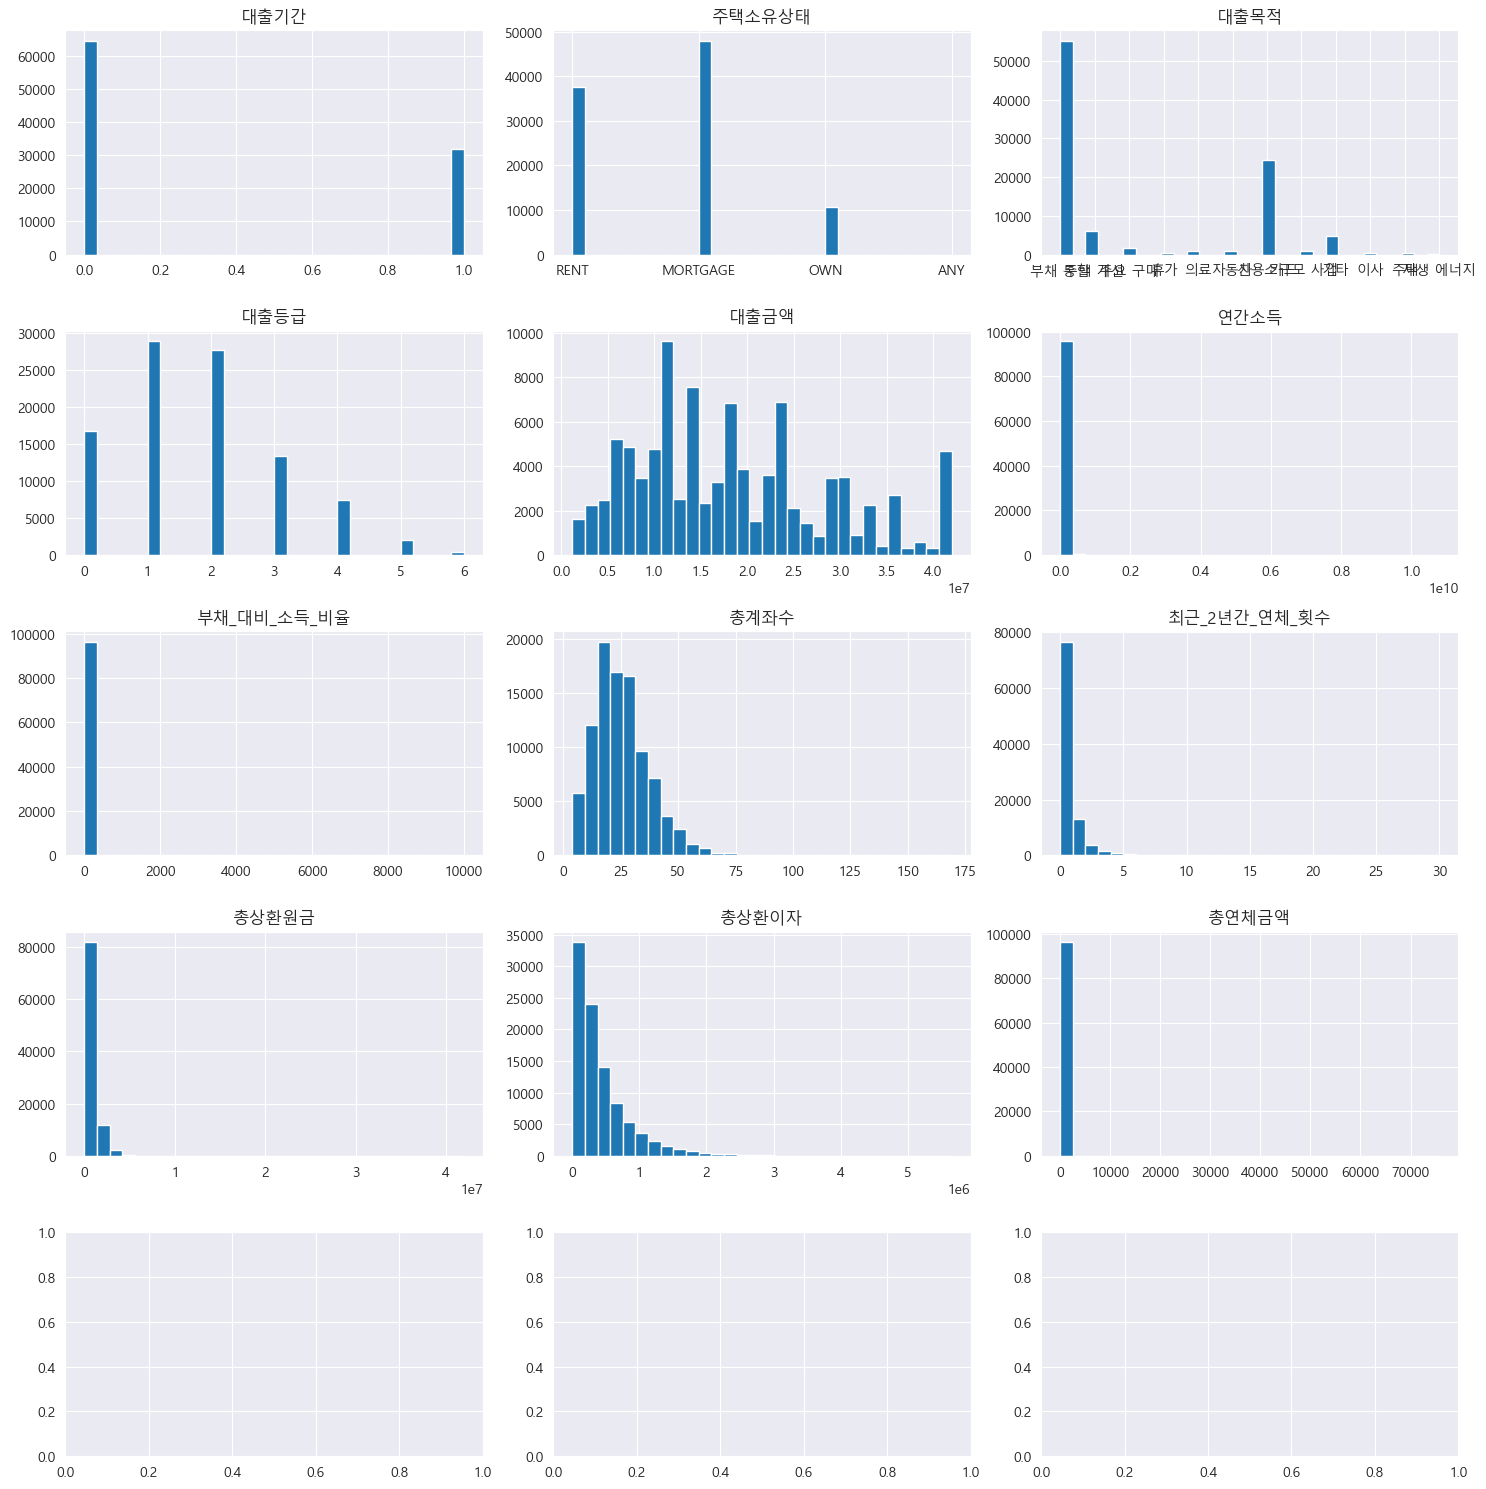

In [50]:
# 4x3 히스토그램 그리기
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(15, 15))
a = 0
numeric_cols = ['대출기간', '주택소유상태','대출목적','대출등급','대출금액', '연간소득', '부채_대비_소득_비율', '총계좌수',
                '최근_2년간_연체_횟수', '총상환원금', '총상환이자', '총연체금액',
                '연체계좌수']

# 각각의 subplot에 히스토그램 그리기
for i in range(4):
    for j in range(3):
        if a < len(numeric_cols):
            axes[i, j].hist(train[numeric_cols[a]], bins=30)
            axes[i, j].set_title(numeric_cols[a])
            a += 1
        else:
            axes[i, j].set_visible(False)  # 비어있는 서브플롯 숨기기

# 레이아웃 조정
plt.tight_layout()

# 그래프 표시
plt.show()

In [21]:
pred = train[train['근로기간'] == -999]
pred.drop('근로기간', axis = 1 ,inplace = True)

C:\Users\SJ\AppData\Local\Temp\ipykernel_30324\3446293159.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred.drop('근로기간', axis = 1 ,inplace = True)


In [22]:
train_1 = train[train['근로기간'] != -999]

In [23]:
X_train1 = train_1.drop('근로기간',axis=1)
X_train1

,대출금액,대출기간,주택소유상태,연간소득,부채_대비_소득_비율,총계좌수,대출목적,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수,대출등급
0,12480000,0,RENT,18.092177,2.990720,2.772589,부채 통합,0.000000,0.000000,0.000000,0.0,0.0,2
1,14400000,1,MORTGAGE,18.689180,3.149740,3.091042,주택 개선,0.000000,12.830869,12.363337,0.0,0.0,1
2,12000000,0,MORTGAGE,18.379859,2.261763,2.708050,부채 통합,0.000000,13.741482,11.931274,0.0,0.0,0
3,14400000,0,MORTGAGE,18.698312,2.778198,2.772589,부채 통합,0.000000,12.694116,11.938905,0.0,0.0,2
4,18000000,1,RENT,18.088503,3.272985,2.995732,주요 구매,0.000000,12.339471,11.911413,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
96289,14400000,0,MORTGAGE,19.162618,2.335052,3.526361,신용 카드,0.000000,13.789763,13.106577,0.0,0.0,2
96290,28800000,1,MORTGAGE,18.698312,1.818077,3.258097,주택 개선,0.000000,13.277192,13.658956,0.0,0.0,4
96291,14400000,0,MORTGAGE,18.246327,2.504709,3.135494,신용 카드,0.000000,14.213702,12.393535,0.0,0.0,0
96292,15600000,0,MORTGAGE,18.010153,2.906901,3.091042,부채 통합,1.098612,14.136411,13.614712,0.0,0.0,3


In [26]:
y_train1 = train_1['근로기간']
y_train1

0        3.0
1        4.0
2        2.0
3        3.0
4        0.0
        ... 
96289    4.0
96290    4.0
96291    1.0
96292    2.0
96293    4.0
Name: 근로기간, Length: 96294, dtype: float64

In [27]:
# 훈련 세트와 검증 세트로 나누기 (비율 80:20)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train1, y_train1, test_size=0.2, random_state=42)

In [28]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96294 entries, 0 to 96293
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   대출금액          96294 non-null  int64   
 1   대출기간          96294 non-null  category
 2   근로기간          96294 non-null  float64 
 3   주택소유상태        96294 non-null  category
 4   연간소득          96294 non-null  float64 
 5   부채_대비_소득_비율   96294 non-null  float64 
 6   총계좌수          96294 non-null  float64 
 7   대출목적          96294 non-null  category
 8   최근_2년간_연체_횟수  96294 non-null  float64 
 9   총상환원금         96294 non-null  float64 
 10  총상환이자         96294 non-null  float64 
 11  총연체금액         96294 non-null  float64 
 12  연체계좌수         96294 non-null  float64 
 13  대출등급          96294 non-null  category
dtypes: category(4), float64(9), int64(1)
memory usage: 7.7 MB


In [31]:
train

,대출금액,대출기간,근로기간,주택소유상태,연간소득,부채_대비_소득_비율,총계좌수,대출목적,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수,대출등급
0,12480000,0,3.0,RENT,18.092177,2.990720,2.772589,부채 통합,0.000000,0.000000,0.000000,0.0,0.0,2
1,14400000,1,4.0,MORTGAGE,18.689180,3.149740,3.091042,주택 개선,0.000000,12.830869,12.363337,0.0,0.0,1
2,12000000,0,2.0,MORTGAGE,18.379859,2.261763,2.708050,부채 통합,0.000000,13.741482,11.931274,0.0,0.0,0
3,14400000,0,3.0,MORTGAGE,18.698312,2.778198,2.772589,부채 통합,0.000000,12.694116,11.938905,0.0,0.0,2
4,18000000,1,0.0,RENT,18.088503,3.272985,2.995732,주요 구매,0.000000,12.339471,11.911413,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96289,14400000,0,4.0,MORTGAGE,19.162618,2.335052,3.526361,신용 카드,0.000000,13.789763,13.106577,0.0,0.0,2
96290,28800000,1,4.0,MORTGAGE,18.698312,1.818077,3.258097,주택 개선,0.000000,13.277192,13.658956,0.0,0.0,4
96291,14400000,0,1.0,MORTGAGE,18.246327,2.504709,3.135494,신용 카드,0.000000,14.213702,12.393535,0.0,0.0,0
96292,15600000,0,2.0,MORTGAGE,18.010153,2.906901,3.091042,부채 통합,1.098612,14.136411,13.614712,0.0,0.0,3


In [35]:
# '주택소유상태'와 '대출목적' 열을 제외
train_modified = train.drop(['주택소유상태', '대출목적'], axis=1)

# 상관계수 계산
correlation_matrix = train_modified.corr()

# 상관계수 출력
print(correlation_matrix)

                  대출금액      대출기간      근로기간      연간소득  부채_대비_소득_비율      총계좌수  \
대출금액          1.000000  0.402573  0.121714  0.520725     0.039114  0.231836   
대출기간          0.402573  1.000000  0.075413  0.121519     0.118997  0.118293   
근로기간          0.121714  0.075413  1.000000  0.201320     0.022870  0.113030   
연간소득          0.520725  0.121519  0.201320  1.000000    -0.220355  0.315825   
부채_대비_소득_비율   0.039114  0.118997  0.022870 -0.220355     1.000000  0.270471   
총계좌수          0.231836  0.118293  0.113030  0.315825     0.270471  1.000000   
최근_2년간_연체_횟수 -0.008644 -0.010931  0.030619  0.076545    -0.012462  0.128887   
총상환원금         0.147948 -0.011087  0.024271  0.088928    -0.018691  0.033941   
총상환이자         0.211223  0.145815  0.030945  0.083116     0.020601  0.039354   
총연체금액        -0.002233  0.004238 -0.000392 -0.000665     0.004043 -0.000414   
연체계좌수         0.000182  0.006988  0.004700  0.019235     0.002629  0.025485   
대출등급          0.137049  0.443839 -0.016345 -0.149930

C:\Users\SJ\anaconda3\envs\study\lib\site-packages\seaborn\utils.py:84: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.draw()
C:\Users\SJ\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


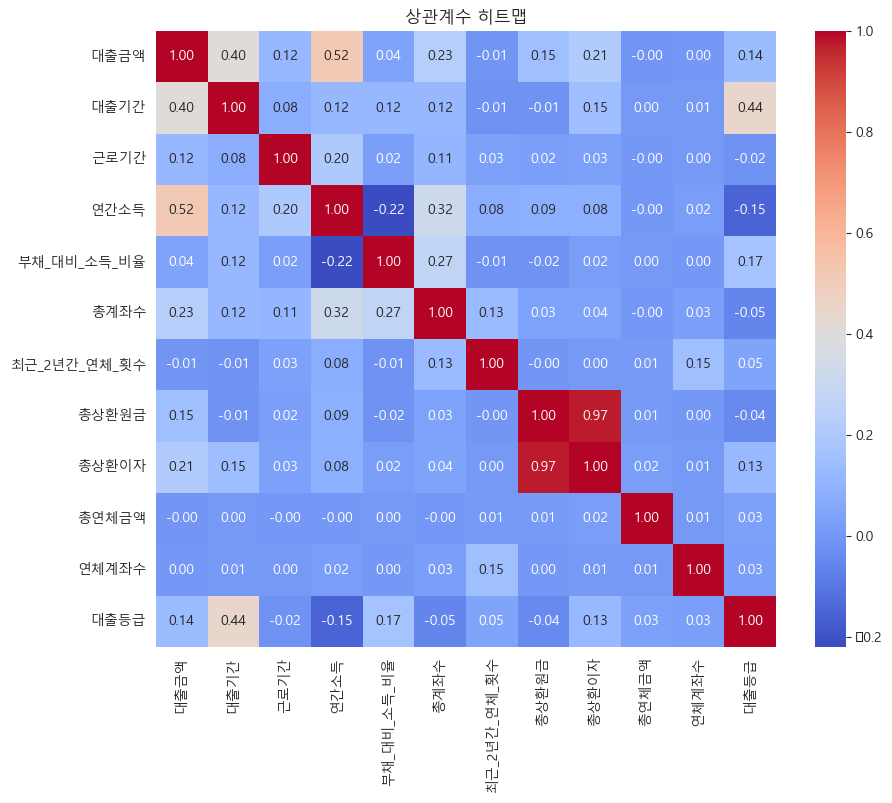

In [38]:
# 히트맵으로 상관계수 시각화
plt.figure(figsize=(10, 8))  # 그래프 크기 설정
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('상관계수 히트맵')
plt.show()

In [51]:
train.to_csv('../data/train_preprocessing.csv', index=False)